In [1]:
import json
import itertools
import zipfile
from datetime import date
from pathlib import Path

import cv2
import rasterio
import utm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from sentinelhub import pixel_to_utm, utm_to_pixel

## Collect the satellite imagery data

In [2]:
# Using pathlib for handling paths which is convientent way. And set path to ../data folder from current context.
data = Path("../data/")

In [41]:
# Set your user and password.
with open("../secrets/sentinel_api_credentials.json", "r") as file:
    credentials = json.load(file)

api = SentinelAPI(credentials["username"], credentials["password"], "https://scihub.copernicus.eu/dhus")

shape = geojson_to_wkt(read_geojson(data / "cameroon.geojson"))

images = api.query(
    area=shape,
    date=(date(2022, 1, 1), date(2023, 3, 1)),
    platformname="Sentinel-2",
    processinglevel = "Level-2A",
    cloudcoverpercentage=(0, 30)
)

images_df = api.to_dataframe(images)

In [42]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, e3eea048-79fd-4f9d-8c3c-450998853276 to ce9ebbbf-e76a-44b4-b098-589a50642b0e
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   title                        5 non-null      object        
 1   link                         5 non-null      object        
 2   link_alternative             5 non-null      object        
 3   link_icon                    5 non-null      object        
 4   summary                      5 non-null      object        
 5   ondemand                     5 non-null      object        
 6   generationdate               5 non-null      datetime64[ns]
 7   beginposition                5 non-null      datetime64[ns]
 8   endposition                  5 non-null      datetime64[ns]
 9   ingestiondate                5 non-null      datetime64[ns]
 10  orbitnumber                  5 non-null      int6

In [43]:
key_columns = ["platformserialidentifier", "processinglevel", "cloudcoverpercentage", 
               "vegetationpercentage", "beginposition"]
images_df[key_columns].head(5)

,platformserialidentifier,processinglevel,cloudcoverpercentage,vegetationpercentage,beginposition
e3eea048-79fd-4f9d-8c3c-450998853276,Sentinel-2A,Level-2A,29.711089,0.000011,2023-02-20 09:30:31.025
68ac67f0-2f5e-43a1-9753-17440ab98c53,Sentinel-2B,Level-2A,1.316282,69.146997,2022-06-10 09:30:39.024
56feb27c-e1c4-41cc-acfe-bfecd6a6d90f,Sentinel-2A,Level-2A,21.922673,56.573832,2022-05-06 09:30:41.024
74c567c7-c8aa-4976-9111-2ec81fccb939,Sentinel-2A,Level-2A,21.873917,46.542847,2022-04-16 09:30:41.024
ce9ebbbf-e76a-44b4-b098-589a50642b0e,Sentinel-2A,Level-2A,17.731680,51.559794,2022-04-06 09:30:41.024


In [44]:
uuids = images_df[images_df["cloudcoverpercentage"] <= 10.0]["uuid"]
uuids

68ac67f0-2f5e-43a1-9753-17440ab98c53    68ac67f0-2f5e-43a1-9753-17440ab98c53
Name: uuid, dtype: object

In [46]:
images_df.loc["68ac67f0-2f5e-43a1-9753-17440ab98c53"]["cloudcoverpercentage"]

1.316282

In [47]:
details = api.download("7518252c-4c05-43eb-80dc-c7f8cea47d2c", directory_path=data)
details

LTATriggered: Product 7518252c-4c05-43eb-80dc-c7f8cea47d2c is not online. Triggered retrieval from the Long Term Archive.

In [30]:
# Extract the zip file and delete it.
if Path(details["path"]).exists():
    with zipfile.ZipFile(details["path"], 'r') as zip_ref:
        print("Extracting and deleting zipfile.")
        zip_ref.extractall(data)

    Path(details["path"]).unlink(missing_ok=True)
else:
    print("Zip file does not exist.")

Extracting and deleting zipfile.


## Understand which spectral band to use and manage quantization.

Quantization is the process of converting continuous data (such as radiance values) into discrete values (such as digital numbers) that can be stored and processed by a computer. This is necessary because computers can't store or process continuous data, so it needs to be discretized into manageable chunks.

In [55]:
def get_band(image_folder, band, resolution=10):

    sub_folder = [f for f in (image_folder / "GRANULE").iterdir() if f.name.startswith("L")][0]
    image_folder  = sub_folder / "IMG_DATA" / f"R{10}m"
    image_files = [im for im in image_folder.iterdir() if im.suffix == ".jp2"]
    selected_file = [im for im in image_files if im.name.split("_")[2] == band][0]
    
    with rasterio.open(selected_file) as file:
        img = file.read(1)
            
    return img

In [56]:
data_1_folder = data / "S2A_MSIL2A_20230220T093031_N0509_R136_T32NQL_20230220T143408.SAFE"

In [57]:
band_dict = {}

for band in ["B02", "B03", "B04", "B08"]:
    band_dict[band] = get_band(data_1_folder, band, 10)

band_dict

{'B02': array([[1866, 1824, 1762, ..., 1398, 1442, 1455],
        [1813, 1794, 1791, ..., 1400, 1419, 1446],
        [1764, 1796, 1762, ..., 1410, 1444, 1478],
        ...,
        [1964, 1965, 1974, ..., 1836, 1838, 1850],
        [2026, 1984, 1963, ..., 1784, 1861, 1867],
        [1973, 1954, 1974, ..., 1846, 1860, 1844]], dtype=uint16),
 'B03': array([[1993, 1950, 1974, ..., 1572, 1592, 1637],
        [1961, 1918, 1956, ..., 1556, 1624, 1638],
        [1948, 1914, 1938, ..., 1612, 1677, 1694],
        ...,
        [2060, 2062, 2058, ..., 1943, 1983, 2040],
        [2078, 2070, 2062, ..., 1950, 1990, 2064],
        [2084, 2098, 2118, ..., 1968, 1996, 2028]], dtype=uint16),
 'B04': array([[2060, 2044, 1861, ..., 1528, 1528, 1610],
        [1963, 1980, 1876, ..., 1518, 1536, 1626],
        [1886, 1866, 1840, ..., 1592, 1676, 1634],
        ...,
        [1899, 1868, 1878, ..., 1913, 1924, 1949],
        [1904, 1867, 1893, ..., 1896, 1912, 1942],
        [1920, 1877, 1910, ..., 1906, 192

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


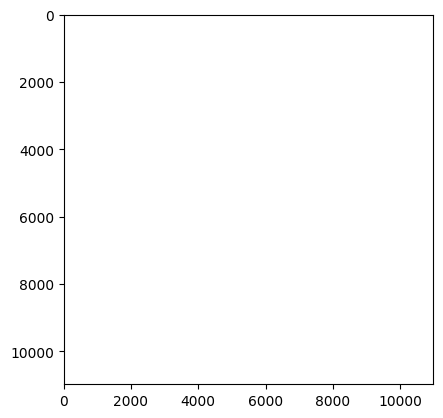

In [58]:
# Recreating an RGB image 
img = cv2.merge((band_dict["B04"], band_dict["B03"], band_dict["B02"]))
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


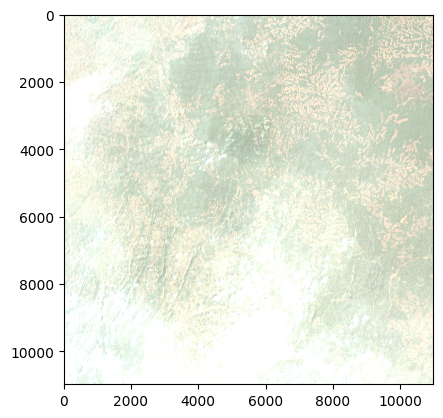

In [59]:
img_processed = img / 8
img_processed = img_processed.astype(int)

plt.imshow(img_processed)

In [60]:
img_processed.shape

(10980, 10980, 3)

## Splitting the images to machine learning ready sizes